In [53]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [54]:
# epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
epsilons = [.06, .08, .1, .12, .14, .16, .18, .2, .22, .24, .26, .28, .3, .32, .34, .36, .38, .4, .42, .44, .46, .48, .5]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [55]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('datatest', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

print(len(datasets.MNIST('datatest')))

CUDA Available:  True
60000


In [56]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [57]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [58]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.06	Test Accuracy = 9281 / 10000 = 0.9281
Epsilon: 0.08	Test Accuracy = 8936 / 10000 = 0.8936
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.12	Test Accuracy = 7943 / 10000 = 0.7943
Epsilon: 0.14	Test Accuracy = 7258 / 10000 = 0.7258
Epsilon: 0.16	Test Accuracy = 6390 / 10000 = 0.639
Epsilon: 0.18	Test Accuracy = 5391 / 10000 = 0.5391
Epsilon: 0.2	Test Accuracy = 4302 / 10000 = 0.4302
Epsilon: 0.22	Test Accuracy = 3347 / 10000 = 0.3347
Epsilon: 0.24	Test Accuracy = 2459 / 10000 = 0.2459
Epsilon: 0.26	Test Accuracy = 1757 / 10000 = 0.1757
Epsilon: 0.28	Test Accuracy = 1218 / 10000 = 0.1218
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869
Epsilon: 0.32	Test Accuracy = 607 / 10000 = 0.0607
Epsilon: 0.34	Test Accuracy = 432 / 10000 = 0.0432
Epsilon: 0.36	Test Accuracy = 301 / 10000 = 0.0301
Epsilon: 0.38	Test Accuracy = 216 / 10000 = 0.0216
Epsilon: 0.4	Test Accuracy = 167 / 10000 = 0.0167
Epsilon: 0.42	Test Accuracy = 131 / 10000 = 0.0131
Epsilon: 0.44	Test Accura

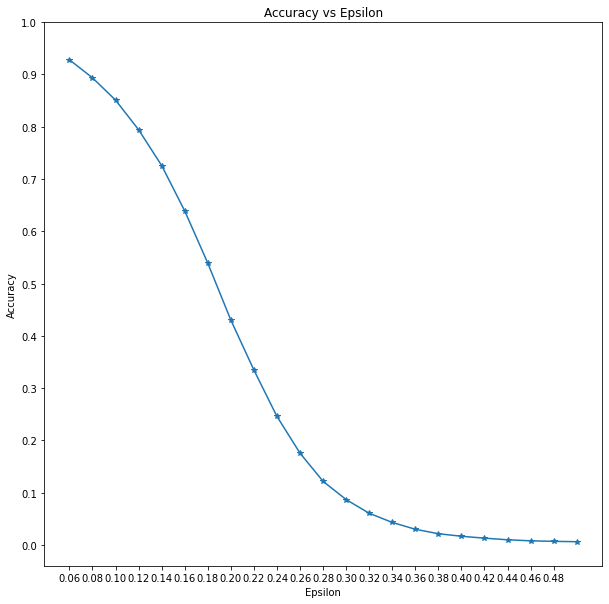

In [59]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(.06, .5, step=0.02))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

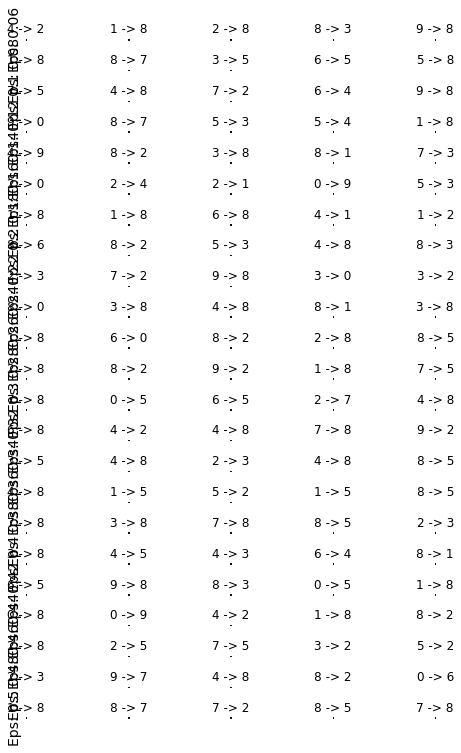

In [60]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        plt.imsave("JPG-PNG-to-MNIST-NN-Format-master/training-images/{}/{}_{}.png".format(orig, i, j), ex, cmap="gray")
        im = Image.open("JPG-PNG-to-MNIST-NN-Format-master/training-images/{}/{}_{}.png".format(orig, i, j))
        im = im.convert('L')
        im.save("JPG-PNG-to-MNIST-NN-Format-master/training-images/{}/{}_{}.png".format(orig, i, j))
        
plt.tight_layout()
plt.show()

In [10]:
# from PIL import Image
 
# #Consider whether you want to use binary image,use OpenCV
# #croped_image = cv2.resize(croped_image, (28, 28),  interpolation=cv2.INTER_CUBIC)
# #ret,croped_image = cv2.threshold(croped_image,190,255,cv2.THRESH_BINARY)
 
# #convert image to binary
# im = Image.open("MM/1_1.png")
# im = im.convert('L')
# im.save("1_1.png")

In [19]:
# train_set = datasets.MNIST('./dataset', train=True, download=True,transform = transforms.Compose([
#                   transforms.ToTensor()
#               ]))
# test_set = datasets.MNIST('./dataset', train=False, download=True,transform = transforms.Compose([
#                   transforms.ToTensor()
#               ]))

In [20]:

# print(train_set)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [21]:
# from torch.utils.data import DataLoader
# train_data = DataLoader(train_set, batch_size=128, shuffle=True)
# train_dataset_array = next(iter(train_data))[0].numpy()
# print(train_dataset_array)

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. 

In [35]:
# import os
# import numpy as np
# import gzip

# # print(os.getcwd())

# def load_data(data_folder):

#   files = [
#       'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
#       'test-labels-idx1-ubyte.gz', 'test-images-idx3-ubyte.gz'
#   ]

#   paths = []
#   for fname in files:
#     paths.append(os.path.join(data_folder,fname))
  

#   with gzip.open(paths[0], 'rb') as lbpath:
#     y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

#   with gzip.open(paths[1], 'rb') as imgpath:
#     x_train = np.frombuffer(
#         imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

#   with gzip.open(paths[2], 'rb') as lbpath:
#     y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

#   with gzip.open(paths[3], 'rb') as imgpath:
#     x_test = np.frombuffer(
#         imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

#   return (x_train, y_train), (x_test, y_test)

# (train_images, train_labels), (test_images, test_labels) = load_data('JPG-PNG-to-MNIST-NN-Format-master/')

In [36]:
# (train_images_old, train_labels_old), (test_images_old, test_labels_old) = keras.datasets.mnist.load_data()

# #https://stackoverflow.com/questions/43153076/how-to-concatenate-numpy-arrays-into-a-specific-shape
# #must have same dim
# train_images_old = train_images_old.reshape(train_images_old.shape[0], 28, 28)
# test_images_old = test_images_old.reshape(test_images_old.shape[0], 28, 28)
# print(type(train_images))
# print(type(train_images_old))
# # train_images, train_labels, test_images, test_labels = [None, None, None, None]

# if type(train_images_old) == type(train_images):
#     print("Type is same, concat/merge datasets...")
#     train_images = np.concatenate((train_images, train_images_old))
#     train_labels = np.concatenate((train_labels, train_labels_old))
#     print(train_images)
#     print(train_labels)
#     test_images = np.concatenate((test_images, test_images_old))
#     test_labels = np.concatenate((test_labels, test_labels_old))
#     print("Merge successed.")

NameError: name 'keras' is not defined